In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import ruptures as rpt
import time as t


global columns
columns = ["time", "device_id", "mac_address", "hostname", "signal_strength", "packets_sent", "packets_received", "bytes_sent", "bytes_received", "errors_sent", "errors_received", "radio_connected", "time_since_connected"]# Connection parameters
conn_params = {
    "host": "10.246.3.111",       # e.g., "127.0.0.1" or server IP
    "port": 5432,           # default PostgreSQL port
    "database": "bulkdata_genie", # database name
    "user": "postgres",   # your username
    "password": ""# your password
}
def get_df():
    conn = get_db_connection()
    if conn is None:
        return None
    
    query = """
    SELECT *
    FROM wifi_stats """
    
    with conn.cursor() as cursor:
        cursor.execute(query)
        results = cursor.fetchall()
        df = pd.DataFrame(results, columns=columns)
    conn.close()
    return df    
# Establish connection
def get_db_connection():
    try:
        conn = psycopg2.connect(**conn_params)
        #print("Connection successful!")
        return conn
    except Exception as e:
        #print("Error connecting to TimeScaleDB:", e)
        return None

df = get_df()

In [ ]:
def tratamento(data, apply_log=False):
    # Criar cópia para evitar modificações no original
    data = data.sort_values(by='time').copy()
    
    # Calcular bytes por minuto de forma mais segura
    data['bytes_sent_per_minute'] = data['bytes_sent'].diff().fillna(0)
    data['bytes_sent_per_minute'] = data['bytes_sent_per_minute'].clip(lower=0)
    
    # Melhor tratamento para logaritmo
    if apply_log:
        # Usar log1p para evitar problemas com zeros
        data['bytes_sent_per_minute'] = np.log1p(data['bytes_sent_per_minute'])
    else:
        # Garantir tipo numérico
        data['bytes_sent_per_minute'] = pd.to_numeric(data['bytes_sent_per_minute'], errors='coerce')
    
    # Detecção de outliers com verificação de dados
    if not data.empty:
        Q1 = data['bytes_sent_per_minute'].quantile(0.25)
        Q3 = data['bytes_sent_per_minute'].quantile(0.75)
        IQR = Q3 - Q1
        if IQR > 0:
            data['is_outlier'] = (data['bytes_sent_per_minute'] < (Q1 - 1.5 * IQR)) | (
                data['bytes_sent_per_minute'] > (Q3 + 1.5 * IQR))
        else:
            data['is_outlier'] = False
    else:
        data['is_outlier'] = False
    
    return data

def detect_change_points(data, penalty=1):
    if data.empty or len(data) < 3:
        return []
    
    signal = data['bytes_sent_per_minute'].values.reshape(-1, 1)
    
    try:
        algo = rpt.Pelt(model="rbf", min_size=3).fit(signal)
        change_points = algo.predict(pen=penalty)  # Usando o parâmetro penalty
        return [data['time'].iloc[cp] for cp in change_points if cp < len(data)]
    except Exception as e:
        print(f"Erro na detecção de change points: {e}")
        return []

def plot_tv_traffic():
    conn = get_db_connection()
    if not conn:
        return

    try:
        df = pd.read_sql("SELECT * FROM wifi_stats", conn)
        # Converter timezone corretamente
        df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert('America/Sao_Paulo')  # Exemplo de timezone válida
        
        # Filtragem mais segura
        mask = (
            (df['mac_address'] == '') &
            (df['time'] >= pd.Timestamp('2025-02-06 1:00').tz_localize('America/Sao_Paulo')) &
            (df['time'] <= pd.Timestamp('2025-02-06 17:27:00').tz_localize('America/Sao_Paulo'))
        )
        tv_data = df.loc[mask].copy()
        
        if tv_data.empty:
            print("Nenhum dado encontrado")
            return
            
        tv_data = tratamento(tv_data)
        change_points = detect_change_points(tv_data, penalty=3)
        
        plt.figure(figsize=(18, 8))
        
        # Plotagem mais robusta
        if not tv_data.empty:
            plt.plot(tv_data['time'], tv_data['bytes_sent_per_minute'], 
                     linestyle='-', color='blue', label='Vazão Normal')
            
            outliers = tv_data[tv_data['is_outlier']]
            if not outliers.empty:
                plt.scatter(outliers['time'], outliers['bytes_sent_per_minute'], 
                           color='red', s=50, edgecolors='black', label='Outliers')
            
            for i, cp in enumerate(change_points):
                label = 'Change Point' if i == 0 else None
                plt.axvline(x=cp, color='green', linestyle='--', 
                           linewidth=2, label=label)
        
        plt.title('Vazão de Dados com Outliers e Change Points')
        plt.xlabel('Horário')
        plt.ylabel('Bytes Enviados por Minuto')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro durante a execução: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == "__main__":
    plot_tv_traffic()

/tmp/ipykernel_56239/1274955684.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM wifi_stats", conn)


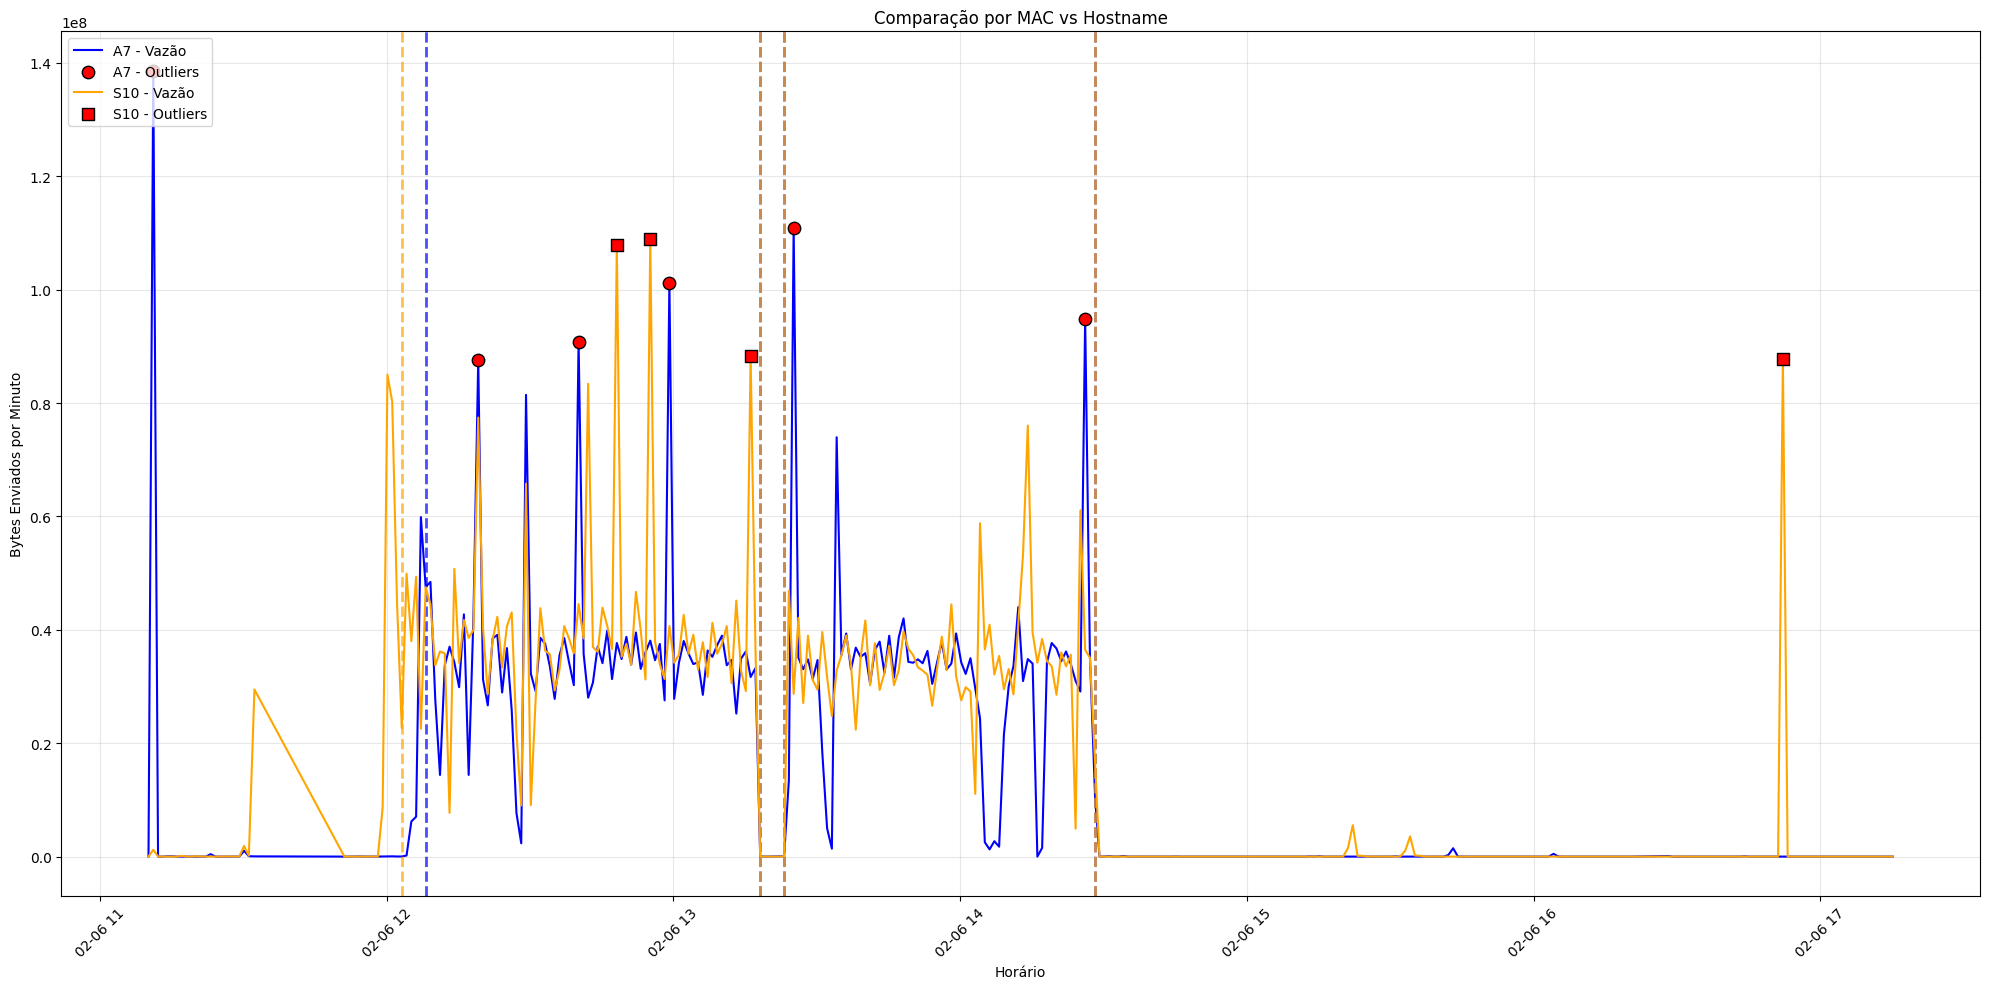

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

def tratamento(data, apply_log=False):
    data = data.sort_values(by='time').copy()
    data['bytes_sent_per_minute'] = data['bytes_sent'].diff().fillna(0)
    data['bytes_sent_per_minute'] = data['bytes_sent_per_minute'].clip(lower=0)
    
    if apply_log:
        data['bytes_sent_per_minute'] = np.log1p(data['bytes_sent_per_minute'])
    else:
        data['bytes_sent_per_minute'] = pd.to_numeric(data['bytes_sent_per_minute'], errors='coerce')
    
    if not data.empty:
        Q1 = data['bytes_sent_per_minute'].quantile(0.25)
        Q3 = data['bytes_sent_per_minute'].quantile(0.75)
        IQR = Q3 - Q1
        data['is_outlier'] = (data['bytes_sent_per_minute'] < (Q1 - 1.5 * IQR)) | (
            data['bytes_sent_per_minute'] > (Q3 + 1.5 * IQR)) if IQR > 0 else False
    else:
        data['is_outlier'] = False
    
    return data

def detect_change_points(data, penalty=1):
    if data.empty or len(data) < 3:
        return []
    
    signal = data['bytes_sent_per_minute'].values.reshape(-1, 1)
    
    try:
        algo = rpt.Pelt(model="rbf", min_size=3).fit(signal)
        change_points = algo.predict(pen=penalty)
        return [data['time'].iloc[cp] for cp in change_points if cp < len(data)]
    except Exception as e:
        print(f"Erro na detecção de change points: {e}")
        return []

def plot_tv_traffic():
    conn = get_db_connection()
    if not conn:
        return

    try:
        # Configuração dos dispositivos
        DEVICES = [
            {
                'filter_type': 'hostname',  # mac ou hostname
                'value': 'Galaxy-A7-2017',
                'name': 'A7',
                'color': 'blue',
                'marker': 'o'
            },
            {
                'filter_type': 'hostname',
                'value': 'Galaxy-S10',
                'name': 'S10',
                'color': 'orange',
                'marker': 's'
            }
        ]

        # Buscar dados
        df = pd.read_sql("SELECT * FROM wifi_stats", conn)
        df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert('America/Sao_Paulo')

        # Criar máscara combinada
        time_mask = (
            df['time'] >= pd.Timestamp('2025-02-06 11:01:00').tz_localize('America/Sao_Paulo')) & (
            df['time'] <= pd.Timestamp('2025-02-06 17:16:00').tz_localize('America/Sao_Paulo'))
        
        device_mask = pd.Series(False, index=df.index)
        for device in DEVICES:
            if device['filter_type'] == 'mac':
                device_mask |= (df['mac_address'] == device['value'])
            elif device['filter_type'] == 'hostname':
                device_mask |= (df['hostname'] == device['value'])

        filtered_data = df[time_mask & device_mask].copy()

        if filtered_data.empty:
            print("Nenhum dado encontrado")
            return

        # Configurar plot
        plt.figure(figsize=(20, 10))
        plt.title('Comparação por MAC vs Hostname')
        plt.xlabel('Horário')
        plt.ylabel('Bytes Enviados por Minuto')

        # Processar cada dispositivo
        for device in DEVICES:
            # Filtrar dados específicos para cada dispositivo
            if device['filter_type'] == 'mac':
                device_data = filtered_data[filtered_data['mac_address'] == device['value']].copy()
            else:
                device_data = filtered_data[filtered_data['hostname'] == device['value']].copy()
            
            if not device_data.empty:
                # Pré-processamento
                device_data = tratamento(device_data)
                change_points = detect_change_points(device_data, penalty=3)

                # Plotar linha principal
                plt.plot(device_data['time'], 
                        device_data['bytes_sent_per_minute'], 
                        color=device['color'], 
                        linestyle='-',
                        linewidth=1.5,
                        label=f"{device['name']} - Vazão")

                # Plotar outliers
                outliers = device_data[device_data['is_outlier']]
                if not outliers.empty:
                    plt.scatter(outliers['time'], 
                               outliers['bytes_sent_per_minute'], 
                               color='red', 
                               s=80,
                               marker=device['marker'],
                               edgecolors='black',
                               zorder=5,
                               label=f"{device['name']} - Outliers")

                # Plotar change points
                for cp in change_points:
                    plt.axvline(x=cp, 
                               color=device['color'], 
                               linestyle='--',
                               alpha=0.7,
                               linewidth=2,
                               label=f"{device['name']} - Change Point")

        # Otimizar legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = {label: handle for handle, label in zip(handles, labels) if "Change Point" not in label or label not in labels}
        plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left')

        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == "__main__":
    plot_tv_traffic()

/tmp/ipykernel_56239/3092247639.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM wifi_stats WHERE hostname = 'TV'", conn)


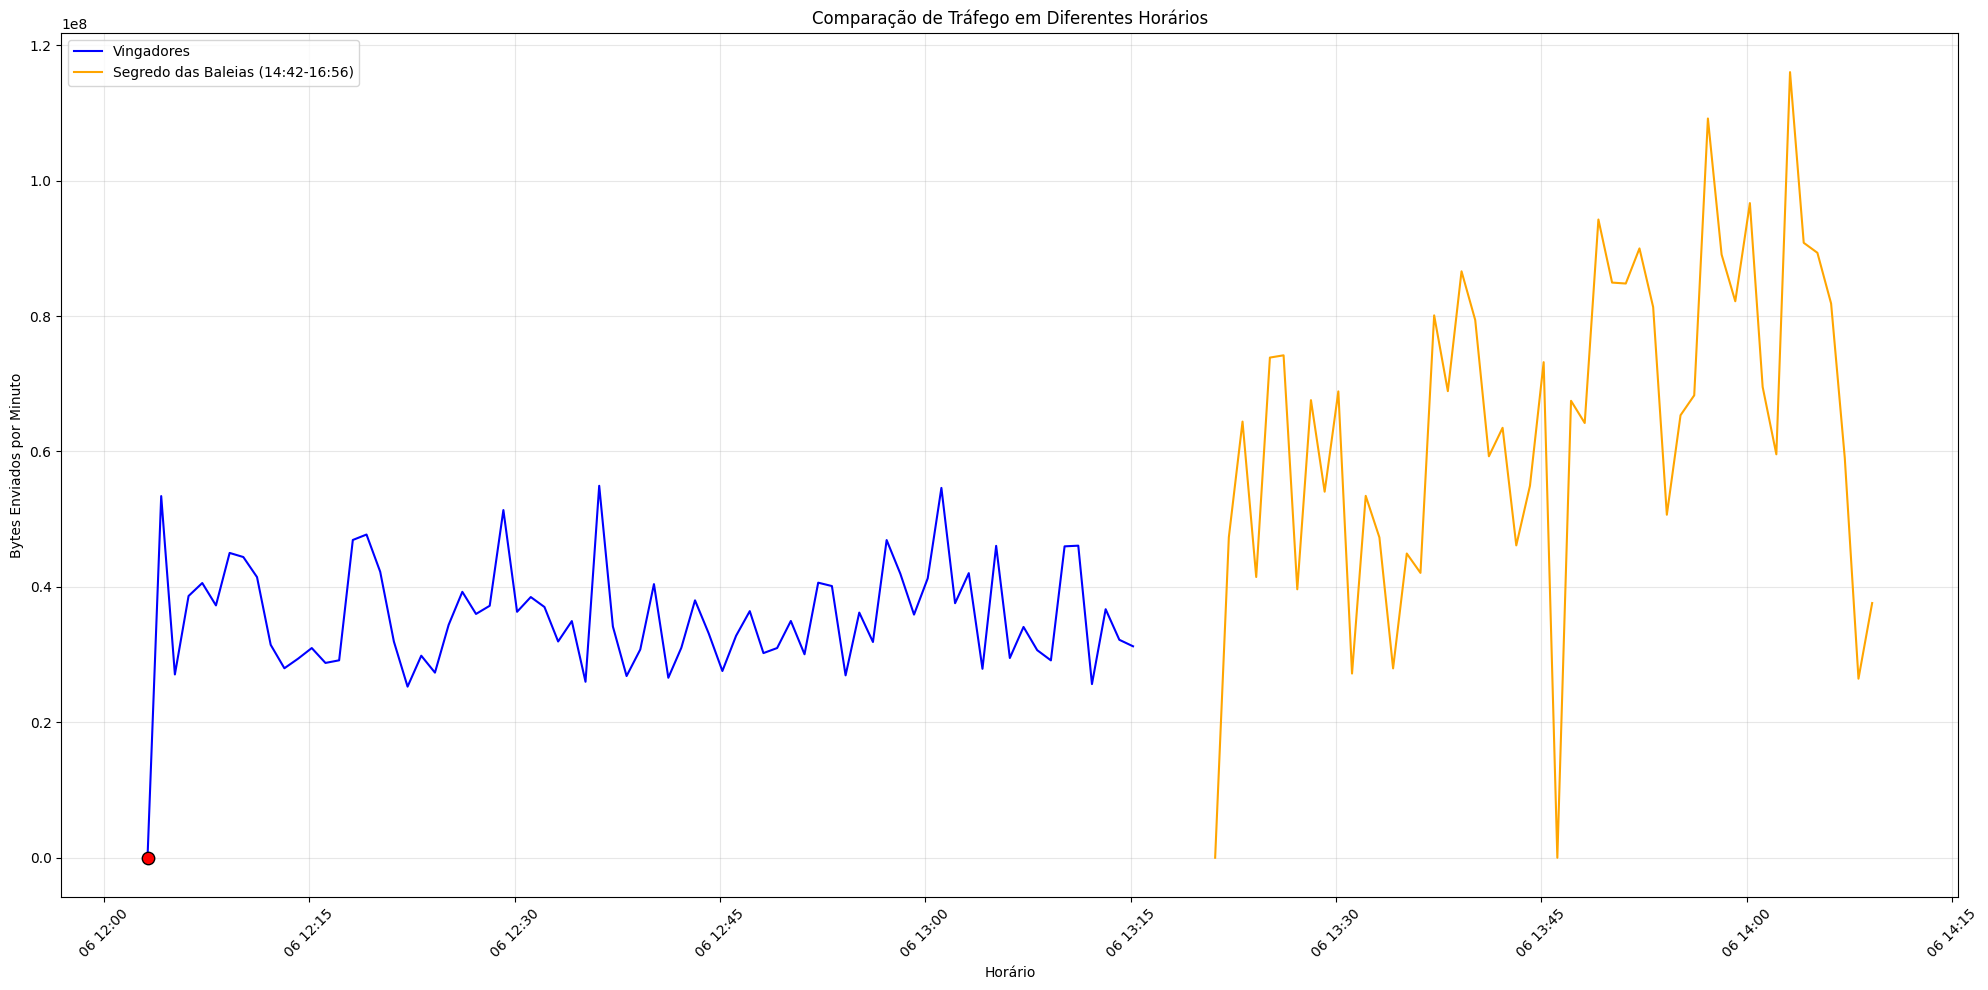

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

def tratamento(data, apply_log=False):
    data = data.sort_values(by='time').copy()
    data['bytes_sent_per_minute'] = data['bytes_sent'].diff().fillna(0)
    data['bytes_sent_per_minute'] = data['bytes_sent_per_minute'].clip(lower=0)
    
    if apply_log:
        data['bytes_sent_per_minute'] = np.log1p(data['bytes_sent_per_minute'])
    else:
        data['bytes_sent_per_minute'] = pd.to_numeric(data['bytes_sent_per_minute'], errors='coerce')
    
    if not data.empty:
        Q1 = data['bytes_sent_per_minute'].quantile(0.25)
        Q3 = data['bytes_sent_per_minute'].quantile(0.75)
        IQR = Q3 - Q1
        data['is_outlier'] = (data['bytes_sent_per_minute'] < (Q1 - 1.5 * IQR)) | (
            data['bytes_sent_per_minute'] > (Q3 + 1.5 * IQR)) if IQR > 0 else False
    else:
        data['is_outlier'] = False
    
    return data

def detect_change_points(data, penalty=1):
    if data.empty or len(data) < 3:
        return []
    
    signal = data['bytes_sent_per_minute'].values.reshape(-1, 1)
    
    try:
        algo = rpt.Pelt(model="rbf", min_size=3).fit(signal)
        change_points = algo.predict(pen=penalty)
        return [data['time'].iloc[cp] for cp in change_points if cp < len(data)]
    except Exception as e:
        print(f"Erro na detecção de change points: {e}")
        return []

def plot_tv_traffic():
    conn = get_db_connection()
    if not conn:
        return

    try:
        # Configuração dos intervalos para o mesmo dispositivo
        INTERVALS = [
            {
                'start': '2025-02-06 12:03:00',
                'end': '2025-02-06 13:16:00',
                'label': 'Vingadores',
                'color': 'blue',
                'marker': 'o'
            },
            {
                'start': '2025-02-06 13:21:00',
                'end': '2025-02-06 14:10:00',
                'label': 'Segredo das Baleias (14:42-16:56)',
                'color': 'orange',
                'marker': 's'
            }
        ]

        # Buscar todos os dados de uma vez
        df = pd.read_sql("SELECT * FROM wifi_stats WHERE hostname = 'TV'", conn)
        df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert('America/Sao_Paulo')

        plt.figure(figsize=(20, 10))
        plt.title('Comparação de Tráfego em Diferentes Horários')
        plt.xlabel('Horário')
        plt.ylabel('Bytes Enviados por Minuto')

        # Processar cada intervalo
        for interval in INTERVALS:
            # Filtrar por intervalo de tempo
            mask = (
                df['time'] >= pd.Timestamp(interval['start']).tz_localize('America/Sao_Paulo')) & (
                df['time'] <= pd.Timestamp(interval['end']).tz_localize('America/Sao_Paulo'))
            
            interval_data = df[mask].copy()
            
            if not interval_data.empty:
                # Processar dados
                processed_data = tratamento(interval_data)
                change_points = detect_change_points(processed_data, penalty=3)

                # Plotar linha principal
                plt.plot(processed_data['time'],
                        processed_data['bytes_sent_per_minute'],
                        color=interval['color'],
                        linestyle='-',
                        linewidth=1.5,
                        label=interval['label'])

                # Plotar outliers
                outliers = processed_data[processed_data['is_outlier']]
                if not outliers.empty:
                    plt.scatter(outliers['time'],
                               outliers['bytes_sent_per_minute'],
                               color='red',
                               s=80,
                               marker=interval['marker'],
                               edgecolors='black',
                               zorder=5,
                               label=f"Outliers - {interval['label']}")

                # Plotar change points
                for cp in change_points:
                    plt.axvline(x=cp,
                               color=interval['color'],
                               linestyle='--',
                               alpha=0.7,
                               linewidth=2,
                               label=f"Change Point - {interval['label']}")

        # Simplificar legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = {}
        for handle, label in zip(handles, labels):
            if "Change Point" not in label and "Outliers" not in label:
                unique_labels[label] = handle
        plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left')

        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == "__main__":
    plot_tv_traffic()